##Deep Learning Project
#phase zero

Mohammad kalbasi:401211028

Farbod Yadollahi: 98102595

AmirMasoud Bagheri:400203616



In [ ]:
# first importing libraries
import base64
import requests
import numpy as np
import gdown
from zipfile import ZipFile
import os

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import pandas as pd
from torchvision.io import read_image
import re
import cv2
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from tqdm import tqdm


installing libraries that we need


for using face_recognition library, you should have a gpu available. (but if that's not the case for you, skip parts that uses face_recognition, we show that it's not best library for face detection and use another library instead)

In [ ]:
!pip install face_recognition
import face_recognition


now installing and importing face_detection library, you can use this library in any runtime type and it doesn't have any limitation

In [ ]:
!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
import face_detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to /tmp/pip-req-build-u9qih061
  Running command git clone --filter=blob:none --quiet https://github.com/hukkelas/DSFD-Pytorch-Inference.git /tmp/pip-req-build-u9qih061
  Resolved https://github.com/hukkelas/DSFD-Pytorch-Inference.git to commit fc1051d80936e3d7a6e34053bb5485c0a032e42e
  Preparing metadata (setup.py) ... done
  Created wheel for face-detection: filename=face_detection-0.2.1-py3-none-any.whl size=29707 sha256=6c8ce22477adf32c73f034d1873ca56919d55109e312fff7a4e73dc43783bb6f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mp8kagmz/wheels/57/d0/53/55657e0e64121cb64c10829c2f29bb3703afd0dcee55416e51
Successfully built face-detection


Main code

loading files from github that we need

In [ ]:
!git clone https://github.com/XL2248/MSCTD.git

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 20.85 MiB/s, done.
Resolving deltas: 100% (617/617), done.
Checking out files: 100% (934/934), done.


mounting drive, we only use this to save downloaded images in there, so next time we want to run code we don't encounter problems like "download limit". 
you can run whole code without any problems, becuse we first download images and then extract them, but make sure that you have enough space on your drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # we use google drive to load files and save models there! so change path files based on your own data and run the code!

Mounted at /content/gdrive


In [ ]:
def donwload_to_file(grdive_path,file_name,output_path):
  """
  function for downloading zip files from google drive and save it to desired path on colab

  inputs:
    grdive_path: path of file we want to download (url should be in export=download format)
    file_name: name of file we want to download
    output_path:path we extract data into
  outputs:
    we dont have any output!

  """
  gdown.download(grdive_path, file_name)
  with ZipFile(file_name, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(output_path)



downloading imgae files of train,validation and test and saving them on images folder.
we save them on google drive, so in next uses we don't need to run this part for downloading, but if it's your first time running the code, you should so it download images from link and save it to your own google drive

In [ ]:
# for train
donwload_to_file('https://drive.google.com/u/0/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj&export=download','train_ende.zip','/content/gdrive/MyDrive/Phase_0_images')

Downloading...
From: https://drive.google.com/u/0/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj&export=download
To: /content/train_ende.zip
100%|██████████| 2.90G/2.90G [00:18<00:00, 153MB/s]


In [ ]:
# renaming train folder name (it's train_ende) to just train so it is more consistent with other folders names
os.rename('/content/gdrive/MyDrive/Phase_0_images/train_ende','/content/gdrive/MyDrive/Phase_0_images/train')


In [ ]:
# for validation
donwload_to_file('https://drive.google.com/u/0/uc?id=12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA&export=download','dev.zip','/content/gdrive/MyDrive/Phase_0_images')

Downloading...
From: https://drive.google.com/u/0/uc?id=12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA&export=download
To: /content/dev.zip
100%|██████████| 638M/638M [00:05<00:00, 120MB/s]


In [ ]:
# for test
donwload_to_file('https://drive.google.com/u/0/uc?id=1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W&export=download','test.zip','/content/gdrive/MyDrive/Phase_0_images')

Downloading...
From: https://drive.google.com/u/0/uc?id=1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W&export=download
To: /content/test.zip
100%|██████████| 641M/641M [00:04<00:00, 131MB/s] 


In [ ]:
"""
data loader class for getting data in video like format (each data has all the images that are belong to a video frame and their corresponding labels and dialogues)
inputs:
  image_path: folder path of image data
  txt_path: folder path of txt data
  language: language type(english,german,...)
  mode: train,test,validation 
  image_format: jpg,png,...
  sclae: upscaling or downscaling image
  transform: transformation we want to apply on data
  target_transform: transformation we want to apply on labels



"""
class MSTCDDate_video(Dataset):
   

  def __init__(self,image_path,txt_path,language,mode,image_format,scale, transform=None, target_transform=None):
     
      text_loader = language + '_' + mode + '.txt'
      sentiment_loader = 'sentiment_' + mode+'.txt'
      index_file = 'image_index_' + mode + '.txt'
      self.image_path = image_path
      self.transform = transform
      self.target_transform = target_transform
      self.mode = mode
      self.image_format = image_format
      self.scale = scale
      for file_names in os.scandir(txt_path):
        name_file = os.path.basename(file_names)
        if name_file == text_loader:
          with open(file_names.path) as f:
            self.text_file = [line.rstrip('\n') for line in f]
        if name_file == sentiment_loader:
          with open(file_names.path) as f:
            self.sentiment_file = [line.rstrip('\n') for line in f]
        if name_file == index_file:
          with open(file_names.path) as f:
            self.index_file = [line.rstrip('\n') for line in f]

  def __len__(self):
      return len(self.index_file)

  def __getitem__(self, idx):
      image_path_complete = self.image_path + '/' + self.mode + '/'
      file_numbers = self.index_file[idx].split(", ")
      file_numbers[0] = file_numbers[0][1:]
      file_numbers[-1] = file_numbers[-1][0:-1]
      array_number = np.asarray(file_numbers).astype('int')
      text_file_chosen = self.text_file[array_number[0]:array_number[-1]+1]
      sentiment_chosen = np.asarray(self.sentiment_file[array_number[0]:array_number[-1]+1]).astype('int')
      temp_image = cv2.imread(image_path_complete+file_numbers[0]+ '.' + self.image_format)
      n1,n2,n3 = np.shape(temp_image)
      image = np.zeros((len(file_numbers),int(n1/self.scale),int(n2/self.scale),n3))
      for i in range(len(file_numbers)):
        image_temp = cv2.imread(image_path_complete+file_numbers[i]+ '.' + self.image_format)
        image[i,:,:,:] = resize(image_temp,[int(n1/self.scale),int(n2/self.scale)], anti_aliasing=True)
      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_transform(sentiment_chosen)
      return file_numbers, text_file_chosen,sentiment_chosen,image

In [ ]:
# loading our data loader
data_train = MSTCDDate_video('/content/gdrive/MyDrive/Phase_0_images','/content/MSCTD/MSCTD_data/ende','english','train','jpg',2)

In [ ]:
# testing our data loader
file_numbers,text_file_chosen,sentiment_chosen,img = data_train[4]

In [ ]:
"""
data loader class for getting data but one image (and it corresponding dialogue and label at a time)
inputs:
  image_path: folder path of image data
  txt_path: folder path of txt data
  language: language type(english,german,...)
  mode: train,test,validation 
  image_format: jpg,png,...
  sclae: upscaling or downscaling image
  transform: transformation we want to apply on data
  target_transform: transformation we want to apply on labels



"""
class MSTCDDate(Dataset):
   

  def __init__(self,image_path,txt_path,language,mode,image_format,scale, transform=None, target_transform=None):
     
      text_loader = language + '_' + mode + '.txt'
      sentiment_loader = 'sentiment_' + mode+'.txt'
      index_file = 'image_index_' + mode + '.txt'
      self.image_path = image_path
      self.transform = transform
      self.target_transform = target_transform
      self.mode = mode
      self.image_format = image_format
      self.scale = scale
      for file_names in os.scandir(txt_path):
        name_file = os.path.basename(file_names)
        if name_file == text_loader:
          with open(file_names.path) as f:
            self.text_file = [line.rstrip('\n') for line in f]
        if name_file == sentiment_loader:
          with open(file_names.path) as f:
            self.sentiment_file = [line.rstrip('\n') for line in f]
        if name_file == index_file:
          with open(file_names.path) as f:
            self.index_file = [line.rstrip('\n') for line in f]

  def __len__(self):
      return len(self.text_file)

  def __getitem__(self, idx):
      image_path_complete = self.image_path + '/' + self.mode + '/'
      text_file_chosen = self.text_file[idx]
      sentiment_chosen = int(self.sentiment_file[idx])
      temp_image = cv2.imread(image_path_complete+str(idx)+ '.' + self.image_format)
      n1,n2,n3 = np.shape(temp_image)
      if self.scale != 1:
        image = resize(temp_image,[int(n1/self.scale),int(n2/self.scale)], anti_aliasing=True)
      else:
        image = temp_image
      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_transform(sentiment_chosen)
      return  text_file_chosen,sentiment_chosen,image

In [ ]:
data_train_2 = MSTCDDate('/content/gdrive/MyDrive/Phase_0_images','/content/MSCTD/MSCTD_data/ende','english','train','jpg',2)
text_file_chosen,sentiment_chosen,img = data_train_2[0]

for face detection, we use haar cascade method and face_recognition and face)detection library, first let's write face detection using haar function and test it:

In [ ]:
haar_cascade = cv2.CascadeClassifier(cv2.samples.findFile
                                    (cv2.data.haarcascades+"haarcascade_frontalface_default.xml"))
def haar_face(img,scale,minNeighbor):
  """
  face detection using haar cascade filters
  inputs:
    img: input image
    scale: scale factor when we use haar cascade method
    minNeighbor: minNeighbor when detecting faces
  output:
    faces: detected faces
  """
  img = (img*255).astype('uint8')
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = haar_cascade.detectMultiScale(gray, scale, minNeighbor)
  return faces


lets test our face detection function

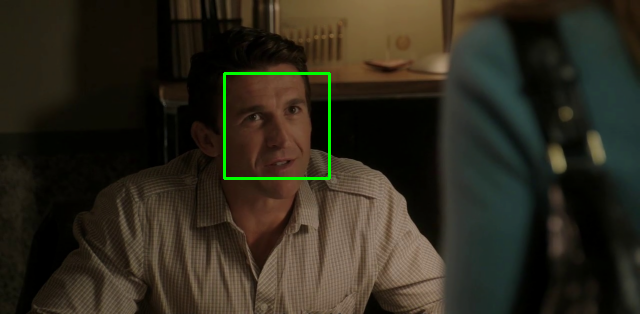

In [ ]:
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[4] # loading file
selected_img = 2
faces = haar_face(image[selected_img,:,:,:], 1.03, 7,)
img = image[selected_img,:,:,:]
img_temp = (img*255).astype('uint8')

for (x, y, w, h) in faces:
    cv2.rectangle(img_temp, (x, y), (x+w, y+h), (0, 255, 0), 2)
cv2_imshow(img_temp)

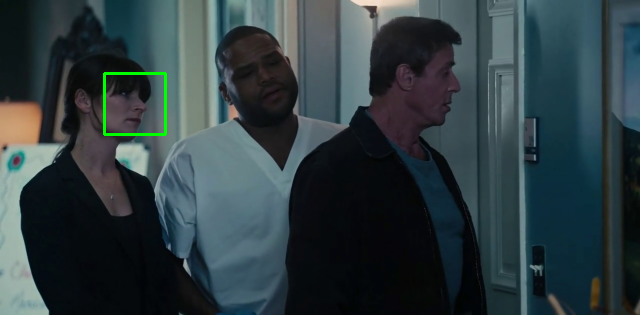

In [ ]:
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[40] # loading file
scale_reduce = 2
selected_img = 2
faces = haar_face(image[selected_img,:,:,:], 1.03, 7,)
img = image[selected_img,:,:,:]
img_temp = ((img)*255).astype('uint8')

for (x, y, w, h) in faces:
    cv2.rectangle(img_temp, (x, y), (x+w, y+h), (0, 255, 0), 2)
cv2_imshow(img_temp)

so it works well but it's not always %110 percent accurate
now lets try using face_recognition library and see it's results

In [ ]:
def face_detection(img):
  """
  face detection using face_recognition library
  inputs:
    img: image (loaded with cv2)
    scale: scale factor 
  output:
    faces: detected faces
  """
  n1,n2,n3 = np.shape(img)
  img_temp = (img*255).astype('uint8')
  img_rgb = cv2.cvtColor(img_temp,cv2.COLOR_BGR2RGB)
  faces = face_recognition.face_locations(img_rgb)
  return faces



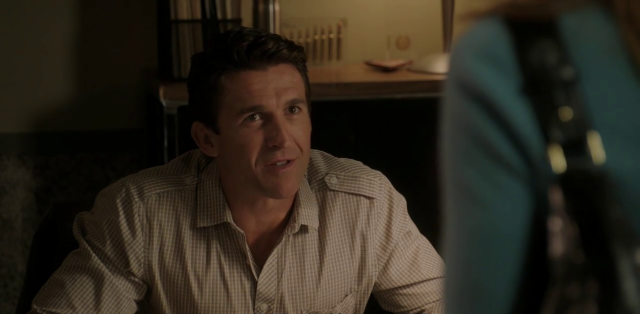

In [ ]:
# testing function
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[4] # loading file
selected_img = 2
face_all = face_detection(image[selected_img,:,:,:])
img = image[selected_img,:,:,:]
img_temp = ((img)*255).astype('uint8')


if (len(face_all) >= 1):
  for i in range(len(face_all)):
    face = face_all[i]
    cv2.rectangle(img_temp, (face[3], face[0]),(face[1], face[2]), (255,0,255), 2)
cv2_imshow(img_temp)


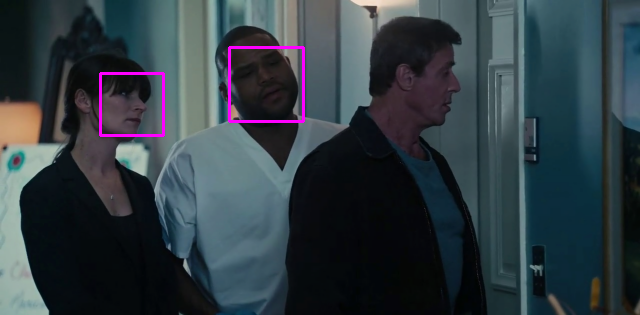

In [ ]:
# testing function
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[40] # loading file
selected_img = 2
face_all = face_detection(image[selected_img,:,:,:])
img = image[selected_img,:,:,:]
img_temp = (img*255).astype('uint8')


if (len(face_all) >= 1):
  for i in range(len(face_all)):
    face = face_all[i]
    cv2.rectangle(img_temp, (face[3], face[0]),(face[1], face[2]), (255,0,255), 2)
cv2_imshow(img_temp)


In [ ]:
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[900] # loading file
np.shape(image)

(10, 629, 1280, 3)

as we can see, this is not perfect either, it couldn't detect any face in first image but results for second image is musch better.
now we try face_detection library.
we test two different methods,DSFDDetector and RetinaNetMobileNetV1, first one is a very deep network so it'll take so much time to detect faces in each image, but it has a very high accuracy, on the other hand RetinaNetMobileNetV1 is much faster and more efficient, but it isn't as accurate as DSFDDetector

In [ ]:
# testing DSFDDetector
# first loading it
detector_dsf = face_detection.build_detector("DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)


Downloading: "https://folk.ntnu.no/haakohu/WIDERFace_DSFD_RES152.pth" to /root/.cache/torch/hub/checkpoints/WIDERFace_DSFD_RES152.pth


  0%|          | 0.00/459M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


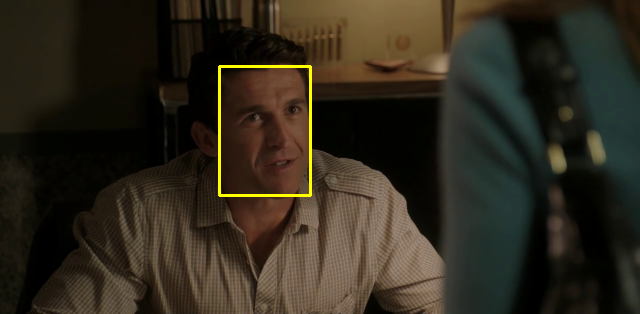

In [ ]:
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[4] # loading file
selected_img = 2
img_temp = ((image[selected_img,:,:,:])*255).astype('uint8')
face_all = detector_dsf.detect(img_temp)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(img_temp, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (0,255,255), 2)
cv2_imshow(img_temp)




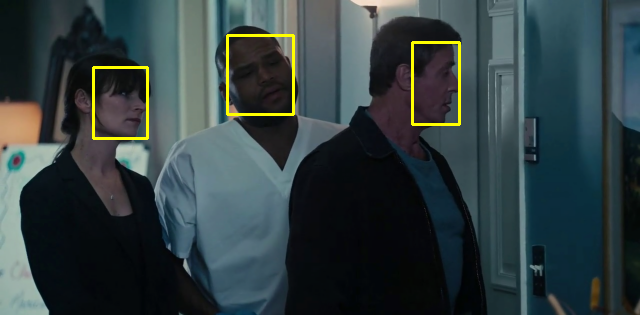

In [ ]:
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[40] # loading file
selected_img = 2
img_temp = ((image[selected_img,:,:,:])*255).astype('uint8')
face_all = detector_dsf.detect(img_temp)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(img_temp, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (0,255,255), 2)
cv2_imshow(img_temp)




In [ ]:
# testing RetinaNetMobileNetV1
# first loading it
detector_mobilenet = face_detection.build_detector("RetinaNetMobileNetV1", confidence_threshold=.5, nms_iou_threshold=.3)


Downloading: "https://folk.ntnu.no/haakohu/RetinaFace_mobilenet025.pth" to /root/.cache/torch/hub/checkpoints/RetinaFace_mobilenet025.pth


  0%|          | 0.00/1.71M [00:00<?, ?B/s]

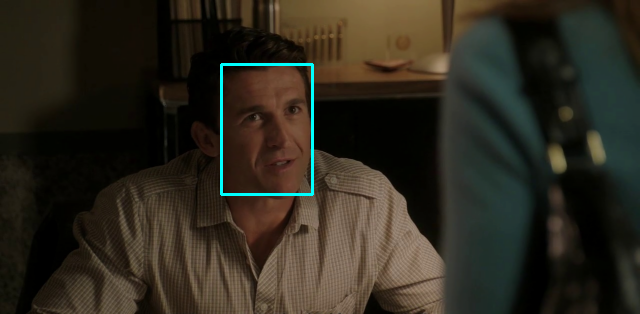

In [ ]:
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[4] # loading file
selected_img = 2
img_temp = ((image[selected_img,:,:,:])*255).astype('uint8')
face_all = detector_mobilenet.detect(img_temp)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(img_temp, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (255,255,0), 2)
cv2_imshow(img_temp)




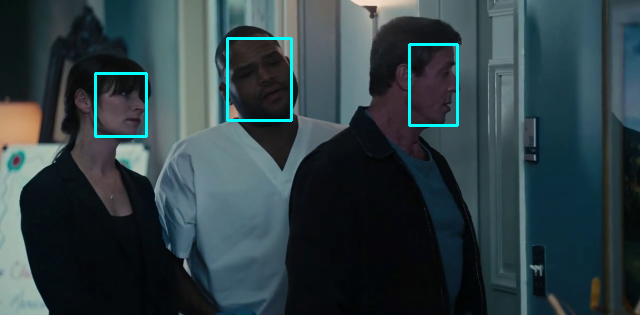

In [ ]:
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[40] # loading file
selected_img = 2
img_temp = ((image[selected_img,:,:,:])*255).astype('uint8')
face_all = detector_mobilenet.detect(img_temp)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(img_temp, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (255,255,0), 2)
cv2_imshow(img_temp)




as we can see, both of them perform very good, but mobilenet is much smaller model (1.7 mb size compared to 497 mb) and runs much faster, to show one case that DSFDDetector works better

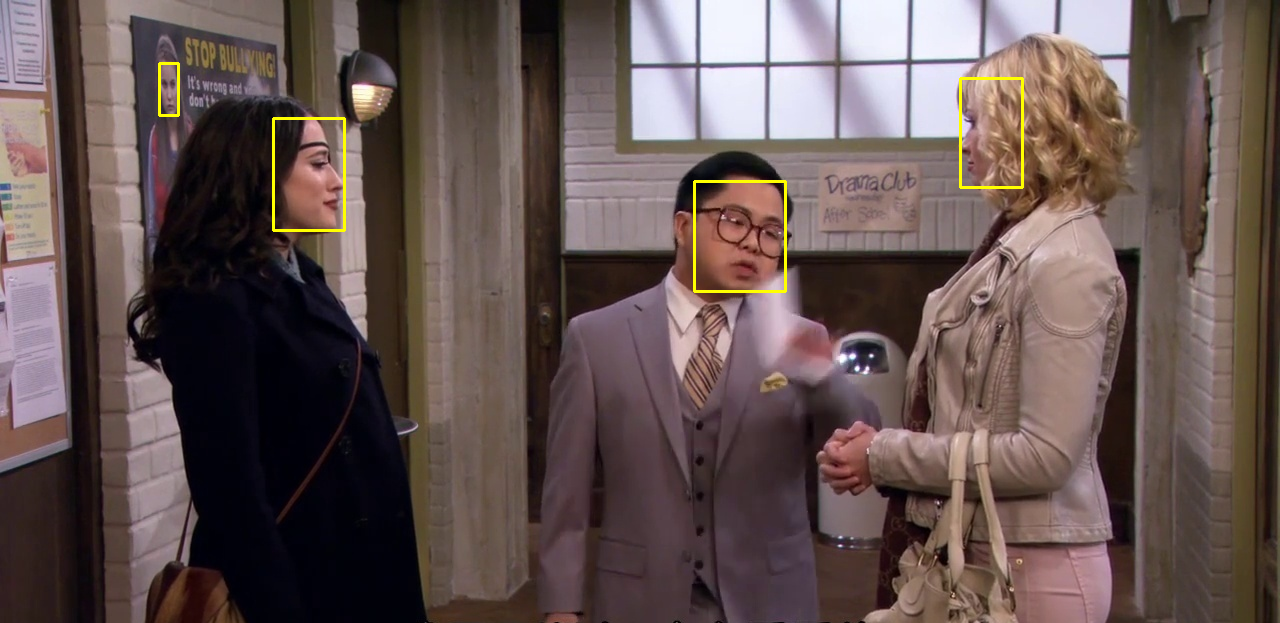

In [ ]:
data_test = MSTCDDate('/content/gdrive/MyDrive/Phase_0_images','/content/MSCTD/MSCTD_data/ende','english','test','jpg',1)
text_file_chosen,sentiment_chosen,img = data_test[5063]

face_all = detector_dsf.detect(img)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(img, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (0,255,255), 2)
cv2_imshow(img)


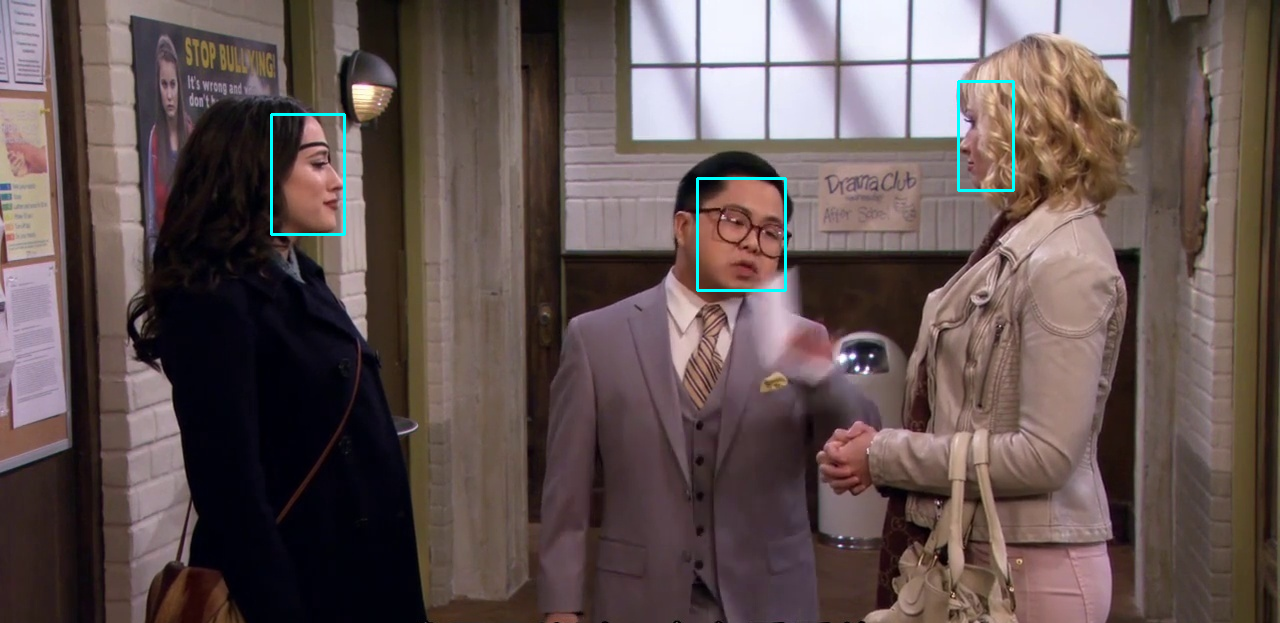

In [ ]:
text_file_chosen,sentiment_chosen,img = data_test[5063]

face_all = detector_mobilenet.detect(img)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(img, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (255,255,0), 2)
cv2_imshow(img)


so mobilenet can't detect small face on poster, and for our task it doesn't really matter, so because of that for counting faces on image we use mobilenet

now we write a function to remove adjacent duplicants

In [ ]:
def remove_adjacent_duplicate(input_arr,):
  """
  function for removing adjacent duplicate of input array, for this purpose, we shift array by one and then compare it to original array, if there is duplicate the value become 0
  so we only choose indexes where value of this diffrentiation is not zero.(we always have to choose first value of array)
  input_arr:
    input array
  outputs:
    output: array without any adjacent duplicate

  """
  input_temp = np.roll(input_arr,1)
  input_temp[0] = -1*input_arr[0] -1 # we use this method to make sure that we always choose first value of array (we now that the x = -1*x -1 dont have answere, so it garauntee that we always include first value of array)
  difference = input_temp - input_arr
  output = input_arr[np.where(difference != 0)]
  return (output)


In [ ]:
# testing  function
file_numbers,text_file_chosen,sentiment_chosen,image = data_train[23] # loading file

print(f"main sentiment = {sentiment_chosen} and when we remove adjacent duplicant : {remove_adjacent_duplicate(sentiment_chosen)}")


main sentiment = [0 1 0 1 0 1 1 1 1 1 1 1 2 0 2 2 0 0 2] and when we remove adjacent duplicant : [0 1 0 1 0 1 2 0 2 0 2]


as we can see, it works!

now lets answer questions, for this part we use our data loader in video format, iterate throgh data and extract parameters that we need and then answer the questions.

In [ ]:
prior_vec = np.zeros((3,))
len_sentence = []
len_image_per_sample = []
face_per_imge_haar = []
face_per_imge_library = []
face_per_imge_face_recon = []
sentiment_pattern = []
len_sentiment_0 = []
len_sentiment_1 = []
len_sentiment_2 = []

scale_reduce  = 2
for i in tqdm(range(len(data_train))):
  file_numbers,text_file_chosen,sentiment_chosen,image = data_train[i] # loading file
  prior_vec[0] = prior_vec[0] + np.sum(sentiment_chosen == 0)
  prior_vec[1] = prior_vec[1] + np.sum(sentiment_chosen == 1)
  prior_vec[2] = prior_vec[2] + np.sum(sentiment_chosen == 2)
  number_image,_,_,_ = np.shape(image)
  sentiment_pattern.append(remove_adjacent_duplicate(sentiment_chosen))
  len_image_per_sample.append(number_image)
  for j in range(number_image):
    img_temp = (((image[j,:,:,:])*255).astype('uint8'))
    face_all =  detector_mobilenet.detect(img_temp)
    face_per_imge_library.append(len(face_all))
    text_splitted = re.findall(r"[\w']+|[.,!?;]", text_file_chosen[j])
    len_sentence.append(text_splitted)
    if sentiment_chosen[j] == 0:
      len_sentiment_0.append(text_splitted)
    elif sentiment_chosen[j] == 1:
      len_sentiment_1.append(text_splitted)
    else:
      len_sentiment_2.append(text_splitted)





    




    

100%|██████████| 2066/2066 [2:16:21<00:00,  3.96s/it]


first we plot prior distribution.

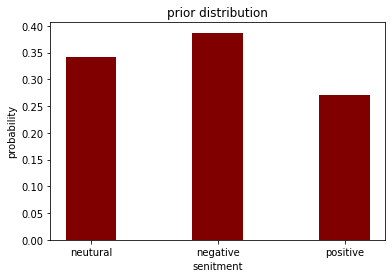

In [ ]:
# prior distribution:
sentiment_list = ['neutural','negative','positive']
values = prior_vec/np.sum(prior_vec) # normalizing sum to make it probability
plt.bar(sentiment_list, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment")
plt.ylabel("probability")
plt.title("prior distribution")
plt.show()

plotting histogram of length of each sentence and then calculating it mean and variance

mean of length of each sentence = 8.087944664031621


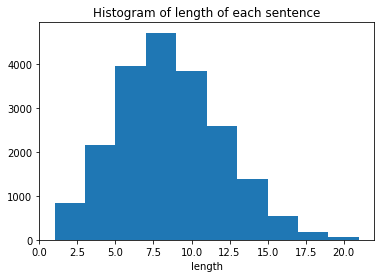

In [ ]:
len_sentence_list = []
for i in range(len(len_sentence)):
  len_sentence_list.append(len(len_sentence[i]))
plt.hist(len_sentence_list)
plt.xlabel('length')
plt.title('Histogram of length of each sentence')


In [ ]:
print(f"mean of length of each sentence = {np.mean(len_sentence_list)}")
print(f"variance of length of each sentence = {np.var(len_sentence_list)}")

mean of length of each sentence = 8.087944664031621
variance of length of each sentence = 11.586040439625677


plotting histogram of number of images in each conversation and then calculating it mean and variance

Text(0.5, 1.0, 'Histogram of number of images in each Conversation')

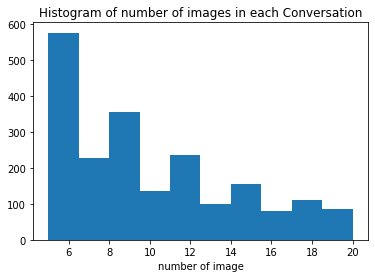

In [ ]:
#number of image in each Conversation
plt.hist(len_image_per_sample)
plt.xlabel('number of image')
plt.title('Histogram of number of images in each Conversation')


In [ ]:
print(f"mean of number of images in each Conversation = {np.mean(len_image_per_sample)}")
print(f"variance of number of images in each Conversation = {np.var(len_image_per_sample)}")

mean of number of images in each Conversation = 9.796708615682478
variance of number of images in each Conversation = 17.69632992187156


plotting histogram of number of faces in each image and then calculating it mean and variance

Text(0.5, 1.0, 'Histogram of number of faces in each image')

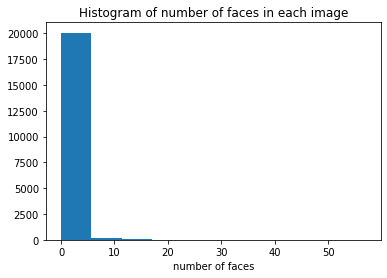

In [ ]:
#number of faces in each image
plt.hist(face_per_imge_library)
plt.xlabel('number of faces')
plt.title('Histogram of number of faces in each image')


In [ ]:
print(f"mean of number of faces in each image = {np.mean(face_per_imge_library)}")
print(f"variance of number of faces in each image = {np.var(face_per_imge_library)}")

mean of number of faces in each image = 1.2686758893280632
variance of number of faces in each image = 2.0006393534502958


If we look at the distribution of number of faces, for some images, we have 30 to 50 faces, they may be just false positive detection of our model, so in order to better see its distribution, if for an image we detected more than ten faces, we only take ten faces from it and plot it histogram and calculate its means and variance to have a better sense of its distribution.

Text(0.5, 1.0, 'Histogram of number of faces in each image')

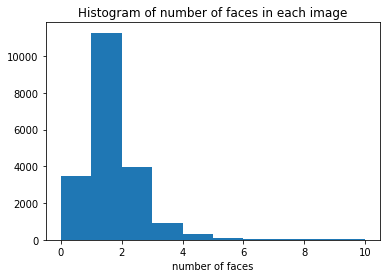

In [ ]:
face_per_imge_library_modified = face_per_imge_library.copy()
face_per_imge_library_modified = np.array(face_per_imge_library_modified) 
face_per_imge_library_modified[face_per_imge_library_modified>10] = 10
plt.hist(face_per_imge_library_modified)
plt.xlabel('number of faces')
plt.title('Histogram of number of faces in each image')

In [ ]:
print(f"mean of number of faces in each image = {np.mean(face_per_imge_library_modified)}")
print(f"variance of number of faces in each image = {np.var(face_per_imge_library_modified)}")

mean of number of faces in each image = 1.2495059288537549
variance of number of faces in each image = 1.179051139292912


first, we plot histogram of each class seperatly, then we plot length of sentece based on each sentiment and in the end, we plot correlation of sentiment and length of sentences

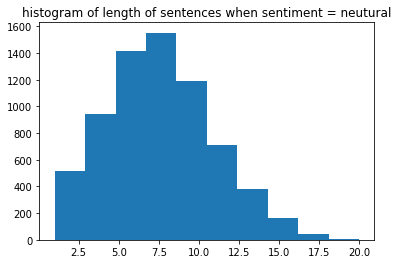

In [ ]:
len_sentence_list_0 = []
len_sentence_list_1 = []
len_sentence_list_2 = []

for i in range(len(len_sentiment_0)):
  len_sentence_list_0.append(len(len_sentiment_0[i]))

for i in range(len(len_sentiment_1)):
  len_sentence_list_1.append(len(len_sentiment_1[i]))

for i in range(len(len_sentiment_2)):
  len_sentence_list_2.append(len(len_sentiment_2[i]))
plt.hist(len_sentence_list_0)
plt.title('histogram of length of sentences when sentiment = neutural')
plt.show()

<ipython-input-149-ec4cf2e796e5>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(len_sentence_list_0)


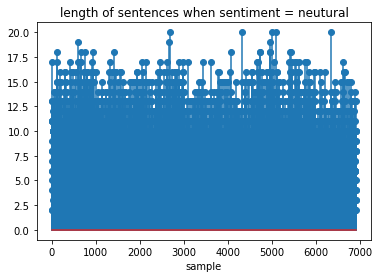

In [ ]:
plt.stem(len_sentence_list_0)
plt.title('length of sentences when sentiment = neutural')
plt.xlabel('sample')
plt.show()

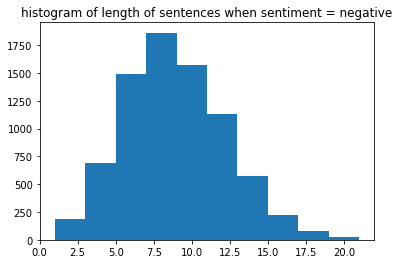

In [ ]:
plt.hist(len_sentence_list_1)
plt.title('histogram of length of sentences when sentiment = negative')
plt.show()

<ipython-input-150-3851cf8869ea>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(len_sentence_list_1)


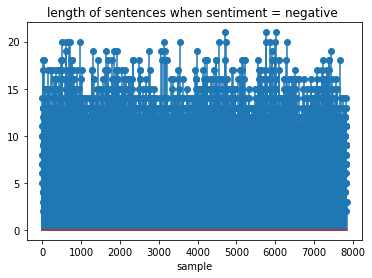

In [ ]:
plt.stem(len_sentence_list_1)
plt.title('length of sentences when sentiment = negative ')
plt.xlabel('sample')
plt.show()

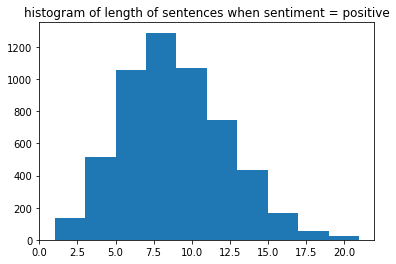

In [ ]:
plt.hist(len_sentence_list_2)
plt.title('histogram of length of sentences when sentiment = positive')
plt.show()

<ipython-input-151-bfb8eb59ecdd>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(len_sentence_list_2)


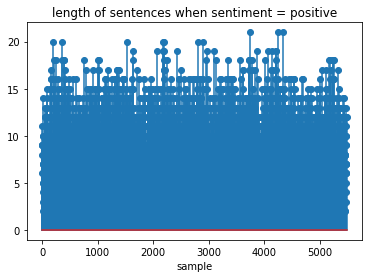

In [ ]:
plt.stem(len_sentence_list_2)
plt.title('length of sentences when sentiment = positive')
plt.xlabel('sample')
plt.show()

now plotting correlation between sentiment and length of conversations

Text(0, 0.5, 'length')

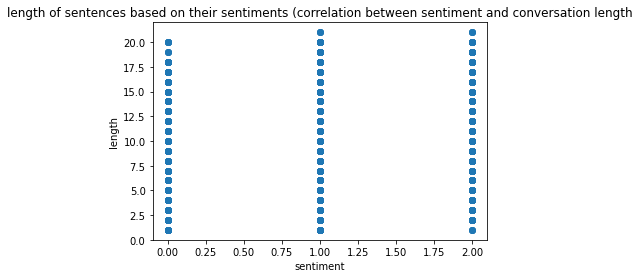

In [ ]:
array_0 = np.asarray(len_sentence_list_0)
array_1 = np.asarray(len_sentence_list_1)
array_2 = np.asarray(len_sentence_list_2)

sentiment_array_0 = np.ones((len(array_0)))*0
sentiment_array_1 = np.ones((len(array_1)))*1
sentiment_array_2 = np.ones((len(array_2)))*2

len_array = np.hstack((array_0,array_1,array_2))
sentiment_array = np.hstack((sentiment_array_0,sentiment_array_1,sentiment_array_2))

plt.scatter(sentiment_array,len_array)
plt.title('length of sentences based on their sentiments (correlation between sentiment and conversation length')
plt.xlabel('sentiment')
plt.ylabel('length')

it is also a good idea to plot sum and mean length of sentences based of their sentiment

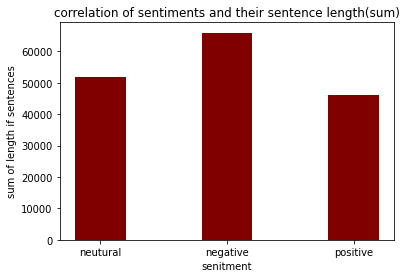

In [ ]:
# now plotting length of sentences based of their sentiment
len_sentence_sentiment = np.zeros((3,))
len_sentence_sentiment[0] = np.sum(len_sentence_list_0)
len_sentence_sentiment[1] = np.sum(len_sentence_list_1)
len_sentence_sentiment[2] = np.sum(len_sentence_list_2)

plt.bar(sentiment_list, len_sentence_sentiment, color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment")
plt.ylabel("sum of length if sentences")
plt.title("correlation of sentiments and their sentence length(sum)")
plt.show()

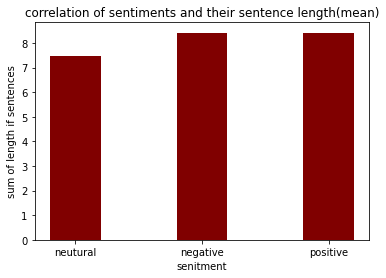

In [ ]:
# now plotting length of sentences based of their sentiment
len_sentence_sentiment = np.zeros((3,))
len_sentence_sentiment[0] = np.mean(len_sentence_list_0)
len_sentence_sentiment[1] = np.mean(len_sentence_list_1)
len_sentence_sentiment[2] = np.mean(len_sentence_list_2)

plt.bar(sentiment_list, len_sentence_sentiment, color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment")
plt.ylabel("sum of length if sentences")
plt.title("correlation of sentiments and their sentence length(mean)")
plt.show()

for plotting histogram of patterns, we should first find unique patterns and then calculate number of their repeats

In [ ]:
# finding unique patterns
def unique_list_func(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return(unique_list)
str_sentiment_pattern = []
for pattern in sentiment_pattern:
  str_pattern = ""
  for character in pattern:
    if character == 0:
      str_pattern = str_pattern + 'neutural_'
    elif character == 1:
      str_pattern = str_pattern + 'negative_'
    else:
      str_pattern = str_pattern + 'positive_'
  str_pattern = str_pattern[0:-1]
  str_sentiment_pattern.append(str_pattern)





In [ ]:
# calculating unique pattern repeats
unique_pattern = unique_list_func(str_sentiment_pattern)
my_dict = {i:str_sentiment_pattern.count(i) for i in unique_pattern}
my_dict


{'neutural_negative': 40,
 'positive_negative_neutural_negative': 17,
 'negative_positive': 20,
 'negative_positive_neutural': 22,
 'negative_neutural': 35,
 'positive_neutural_negative_neutural': 12,
 'neutural_positive_neutural_negative_neutural_negative_positive': 3,
 'neutural_negative_positive_negative_neutural': 10,
 'neutural_negative_neutural': 61,
 'neutural_negative_neutural_negative_positive_neutural_negative': 5,
 'negative_positive_neutural_negative_neutural': 8,
 'positive_neutural_negative_neutural_negative': 4,
 'negative_neutural_negative': 39,
 'positive_neutural_negative_positive_negative_neutural_positive_neutural_negative': 1,
 'positive_negative_neutural_negative_neutural_negative_neutural': 2,
 'negative_neutural_positive_neutural_negative_neutural_positive_neutural': 1,
 'neutural_positive_negative_neutural': 15,
 'negative_positive_negative_neutural_negative_neutural_negative_positive_neutural_negative_positive': 1,
 'positive_negative_positive_negative_neutura

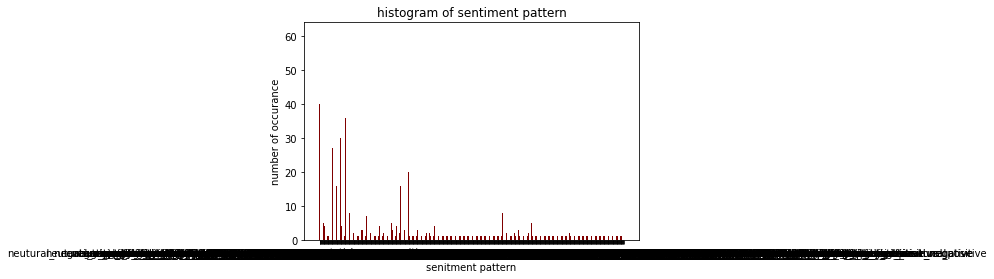

In [ ]:
plt.bar(my_dict.keys(), my_dict.values(), color ='maroon',
        width = 0.4)
# plotting it histogram
plt.xlabel("senitment pattern")
plt.ylabel("number of occurance")
plt.title("histogram of sentiment pattern")
plt.show()

In [ ]:
print(f"number of all sentiment patterns = {len(unique_pattern)}")
mean_of_conv = np.round(np.mean(len_image_per_sample))
possible = 3 * (2**(mean_of_conv-1))
print(f"number of all possible sentiment patterns = {int(possible)}")



number of all sentiment patterns = 681
number of all possible sentiment patterns = 1536


so, roughly we only see half of possible patterns in our data, but so many of this pattern are happening once or twice and there aren't that many pattern that happe more than 10 times(which could cause bias if we train in video format)

conclusion:
if we see prior distribution, they all nearly have same value bot we see negative sentiment the most.
if we compare distribution of length of sentences based of sentiments, whey also are very close together so we can assume that when we train data, we wont have biases

now we do all of this for validation and test data

first for validation

In [ ]:
data_valid = MSTCDDate_video('/content/gdrive/MyDrive/Phase_0_images','/content/MSCTD/MSCTD_data/ende','english','dev','jpg',2)


In [ ]:
prior_vec_v = np.zeros((3,))
len_sentence_v = []
len_image_per_sample_v = []
face_per_imge_library_v = []
face_per_imge_face_recon_v = []
sentiment_pattern_v = []
len_sentiment_0_v = []
len_sentiment_1_v = []
len_sentiment_2_v = []

scale_reduce  = 2
for i in tqdm(range(len(data_valid))):
  file_numbers,text_file_chosen,sentiment_chosen,image = data_valid[i] # loading file
  prior_vec_v[0] = prior_vec_v[0] + np.sum(sentiment_chosen == 0)
  prior_vec_v[1] = prior_vec_v[1] + np.sum(sentiment_chosen == 1)
  prior_vec_v[2] = prior_vec_v[2] + np.sum(sentiment_chosen == 2)
  number_image,_,_,_ = np.shape(image)
  sentiment_pattern_v.append(remove_adjacent_duplicate(sentiment_chosen))
  len_image_per_sample_v.append(number_image)
  for j in range(number_image):
    img_temp = (((image[j,:,:,:])*255).astype('uint8'))
    face_all =  detector_mobilenet.detect(img_temp)
    face_per_imge_library_v.append(len(face_all))
    text_splitted = re.findall(r"[\w']+|[.,!?;]", text_file_chosen[j])
    len_sentence_v.append(text_splitted)
    if sentiment_chosen[j] == 0:
      len_sentiment_0_v.append(text_splitted)
    elif sentiment_chosen[j] == 1:
      len_sentiment_1_v.append(text_splitted)
    else:
      len_sentiment_2_v.append(text_splitted)





    




    

100%|██████████| 504/504 [08:40<00:00,  1.03s/it]


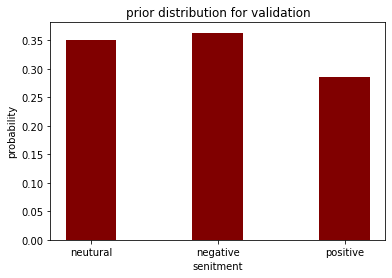

In [ ]:
# prior distribution:
sentiment_list = ['neutural','negative','positive']
values = prior_vec_v/np.sum(prior_vec_v)
plt.bar(sentiment_list, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment")
plt.ylabel("probability")
plt.title("prior distribution for validation")
plt.show()

Text(0.5, 1.0, 'Histogram of length of each sentence in validation data')

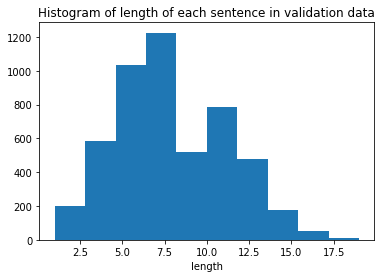

In [ ]:
len_sentence_list = []
for i in range(len(len_sentence_v)):
  len_sentence_list.append(len(len_sentence_v[i]))
plt.hist(len_sentence_list)
plt.xlabel('length')
plt.title('Histogram of length of each sentence in validation data')


In [ ]:
print(f"mean of length of each sentence (validation) = {np.mean(len_sentence_list)}")
print(f"variance of length of each sentence (validation) = {np.var(len_sentence_list)}")

mean of length of each sentence (validation) = 7.850483902824412
variance of length of each sentence (validation) = 10.39656652467669


Text(0.5, 1.0, 'Histogram of number of images in each Conversation for validation data')

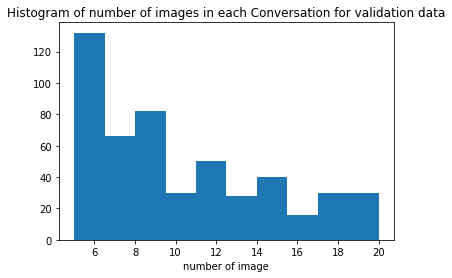

In [ ]:
#number of image in each Conversation
plt.hist(len_image_per_sample_v)
plt.xlabel('number of image')
plt.title('Histogram of number of images in each Conversation for validation data')


In [ ]:
print(f"mean of number of images in each Conversation(validation) = {np.mean(len_image_per_sample_v)}")
print(f"variance of number of images in each Conversation(validation) = {np.var(len_image_per_sample_v)}")

mean of number of images in each Conversation(validation) = 10.045634920634921
variance of number of images in each Conversation(validation) = 19.253869834971024


Text(0.5, 1.0, 'Histogram of number of faces in each image for validation data')

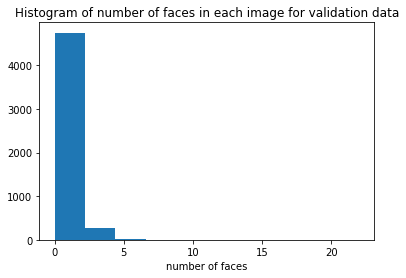

In [ ]:
#number of faces in each image
plt.hist(face_per_imge_library_v)
plt.xlabel('number of faces')
plt.title('Histogram of number of faces in each image for validation data')


In [ ]:
print(f"mean of number of faces in each image(validation) = {np.mean(face_per_imge_library_v)}")
print(f"variance of number of faces in each image(validation) = {np.var(face_per_imge_library_v)}")

mean of number of faces in each image(validation) = 1.1979063796168279
variance of number of faces in each image(validation) = 0.9262685774489313


Text(0.5, 1.0, 'Histogram of number of faces in each image for validation data')

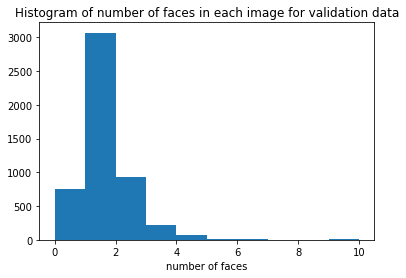

In [ ]:
face_per_imge_library_modified = face_per_imge_library_v.copy()
face_per_imge_library_modified = np.array(face_per_imge_library_modified) 
face_per_imge_library_modified[face_per_imge_library_modified>10] = 10
plt.hist(face_per_imge_library_modified)
plt.xlabel('number of faces')
plt.title('Histogram of number of faces in each image for validation data')

In [ ]:
print(f"mean of number of faces in each image(validation) = {np.mean(face_per_imge_library_modified)}")
print(f"variance of number of faces in each image(validation) = {np.var(face_per_imge_library_modified)}")

mean of number of faces in each image(validation) = 1.1929685956942524
variance of number of faces in each image(validation) = 0.7984336721324737


now for correlation on validation data

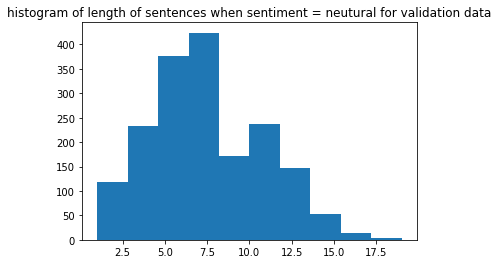

In [ ]:
len_sentence_list_0 = []
len_sentence_list_1 = []
len_sentence_list_2 = []

for i in range(len(len_sentiment_0_v)):
  len_sentence_list_0.append(len(len_sentiment_0_v[i]))

for i in range(len(len_sentiment_1_v)):
  len_sentence_list_1.append(len(len_sentiment_1_v[i]))

for i in range(len(len_sentiment_2_v)):
  len_sentence_list_2.append(len(len_sentiment_2_v[i]))
plt.hist(len_sentence_list_0)
plt.title('histogram of length of sentences when sentiment = neutural for validation data')
plt.show()

<ipython-input-141-8b1df45c44a7>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(len_sentence_list_0)


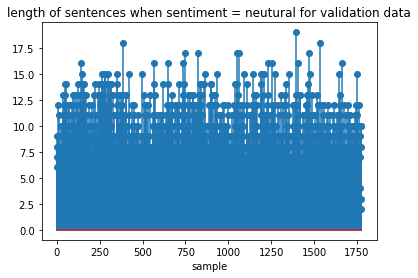

In [ ]:
plt.stem(len_sentence_list_0)
plt.title('length of sentences when sentiment = neutural for validation data')
plt.xlabel('sample')
plt.show()

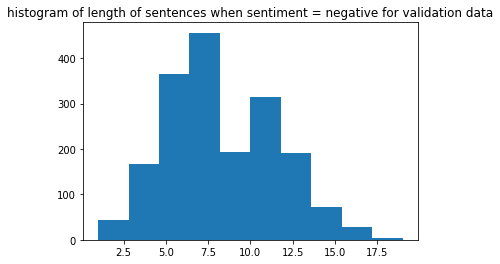

In [ ]:
plt.hist(len_sentence_list_1)
plt.title('histogram of length of sentences when sentiment = negative for validation data')
plt.show()

<ipython-input-142-a828d1f4af3b>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(len_sentence_list_1)


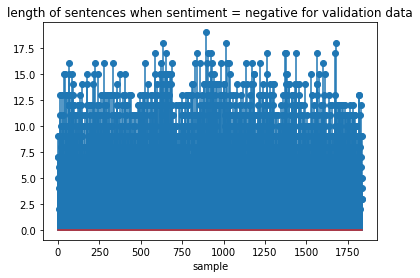

In [ ]:
plt.stem(len_sentence_list_1)
plt.title('length of sentences when sentiment = negative for validation data')
plt.xlabel('sample')
plt.show()

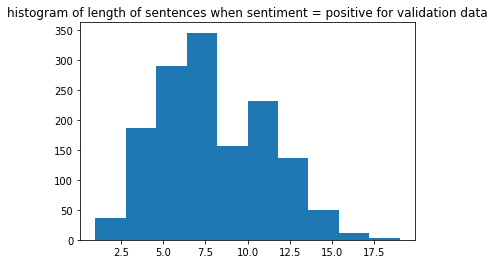

In [ ]:
plt.hist(len_sentence_list_2)
plt.title('histogram of length of sentences when sentiment = positive for validation data')
plt.show()

<ipython-input-143-35d4c61fd904>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(len_sentence_list_2)


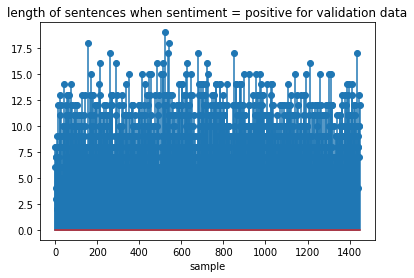

In [ ]:
plt.stem(len_sentence_list_2)
plt.title('length of sentences when sentiment = positive for validation data')
plt.xlabel('sample')
plt.show()

Text(0, 0.5, 'length')

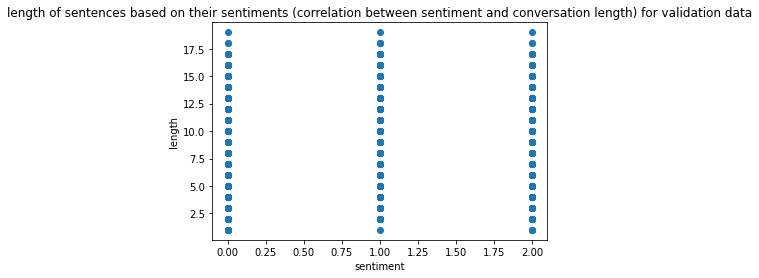

In [ ]:
array_0 = np.asarray(len_sentence_list_0)
array_1 = np.asarray(len_sentence_list_1)
array_2 = np.asarray(len_sentence_list_2)

sentiment_array_0 = np.ones((len(array_0)))*0
sentiment_array_1 = np.ones((len(array_1)))*1
sentiment_array_2 = np.ones((len(array_2)))*2

len_array = np.hstack((array_0,array_1,array_2))
sentiment_array = np.hstack((sentiment_array_0,sentiment_array_1,sentiment_array_2))

plt.scatter(sentiment_array,len_array)
plt.title('length of sentences based on their sentiments (correlation between sentiment and conversation length) for validation data')
plt.xlabel('sentiment')
plt.ylabel('length')

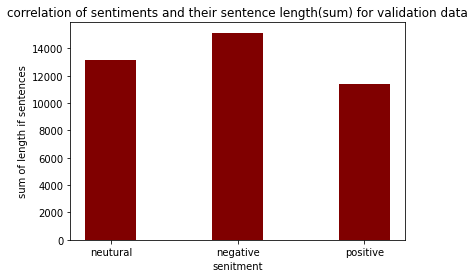

In [ ]:
# now plotting length of sentences based of their sentiment
len_sentence_sentiment = np.zeros((3,))
len_sentence_sentiment[0] = np.sum(len_sentence_list_0)
len_sentence_sentiment[1] = np.sum(len_sentence_list_1)
len_sentence_sentiment[2] = np.sum(len_sentence_list_2)

plt.bar(sentiment_list, len_sentence_sentiment, color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment")
plt.ylabel("sum of length if sentences")
plt.title("correlation of sentiments and their sentence length(sum) for validation data")
plt.show()

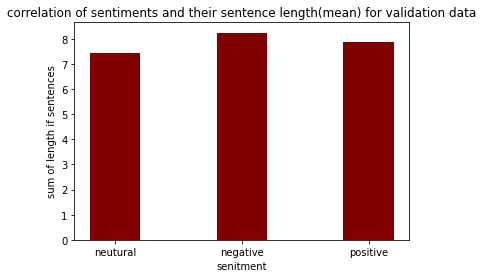

In [ ]:
# now plotting length of sentences based of their sentiment
len_sentence_sentiment = np.zeros((3,))
len_sentence_sentiment[0] = np.mean(len_sentence_list_0)
len_sentence_sentiment[1] = np.mean(len_sentence_list_1)
len_sentence_sentiment[2] = np.mean(len_sentence_list_2)

plt.bar(sentiment_list, len_sentence_sentiment, color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment")
plt.ylabel("sum of length if sentences")
plt.title("correlation of sentiments and their sentence length(mean) for validation data")
plt.show()

In [ ]:
str_sentiment_pattern = []
for pattern in sentiment_pattern_v:
  str_pattern = ""
  for character in pattern:
    if character == 0:
      str_pattern = str_pattern + 'neutural_'
    elif character == 1:
      str_pattern = str_pattern + 'negative_'
    else:
      str_pattern = str_pattern + 'positive_'
  str_pattern = str_pattern[0:-1]
  str_sentiment_pattern.append(str_pattern)


In [ ]:
unique_pattern = unique_list_func(str_sentiment_pattern)
my_dict = {i:str_sentiment_pattern.count(i) for i in unique_pattern}
my_dict


{'neutural_negative_neutural_negative_neutural_positive_negative_neutural_negative': 1,
 'neutural_negative_neutural_negative_neutural_positive_neutural': 1,
 'neutural_negative_neutural_positive': 3,
 'neutural_positive_neutural_negative_neutural_negative': 1,
 'neutural_negative_neutural_negative_neutural': 8,
 'negative_neutural_positive_neutural_positive_neutural_positive': 1,
 'neutural_positive_neutural': 19,
 'positive_neutural': 10,
 'neutural': 18,
 'neutural_positive_neutural_positive': 3,
 'positive_neutural_negative_neutural_positive_neutural': 1,
 'neutural_negative_neutural_negative_neutural_positive': 1,
 'negative_neutural_negative_positive_negative_neutural_positive_neutural': 1,
 'neutural_positive_negative_neutural': 6,
 'positive_neutural_positive_neutural': 5,
 'positive_neutural_positive_neutural_positive_neutural_negative_neutural_negative_positive': 1,
 'neutural_negative': 6,
 'neutural_negative_neutural_positive_neutural': 3,
 'neutural_positive': 7,
 'positiv

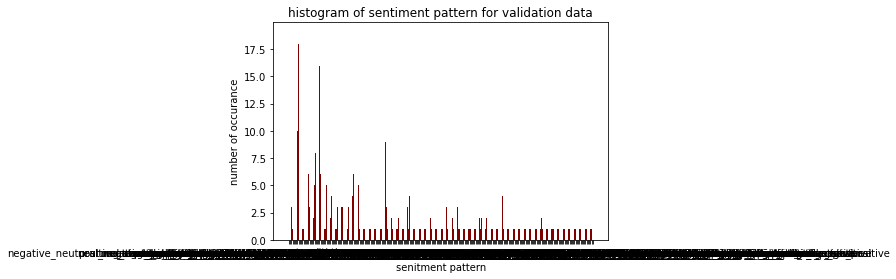

In [ ]:
plt.bar(my_dict.keys(), my_dict.values(), color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment pattern")
plt.ylabel("number of occurance")
plt.title("histogram of sentiment pattern for validation data")
plt.show()

In [ ]:
print(f"number of all sentiment patterns in validation data= {len(unique_pattern)}")
mean_of_conv = np.round(np.mean(len_image_per_sample_v))
possible = 3 * (2**(mean_of_conv-1))
print(f"number of all possible sentiment patterns for validation data = {int(possible)}")



number of all sentiment patterns in validation data= 250
number of all possible sentiment patterns for validation data = 1536


for test data

In [ ]:
data_test = MSTCDDate_video('/content/gdrive/MyDrive/Phase_0_images','/content/MSCTD/MSCTD_data/ende','english','test','jpg',2)


In [ ]:
prior_vec_t = np.zeros((3,))
len_sentence_t = []
len_image_per_sample_t = []
face_per_imge_library_t = []
sentiment_pattern_t = []
len_sentiment_0_t = []
len_sentiment_1_t = []
len_sentiment_2_t = []

scale_reduce  = 2
for i in tqdm(range(len(data_test))):
  file_numbers,text_file_chosen,sentiment_chosen,image = data_test[i] # loading file
  prior_vec_t[0] = prior_vec_v[0] + np.sum(sentiment_chosen == 0)
  prior_vec_t[1] = prior_vec_v[1] + np.sum(sentiment_chosen == 1)
  prior_vec_t[2] = prior_vec_v[2] + np.sum(sentiment_chosen == 2)
  number_image,_,_,_ = np.shape(image)
  sentiment_pattern_t.append(remove_adjacent_duplicate(sentiment_chosen))
  len_image_per_sample_t.append(number_image)
  for j in range(number_image):
    img_temp = (((image[j,:,:,:])*255).astype('uint8'))
    face_all =  detector_mobilenet.detect(img_temp)
    face_per_imge_library_t.append(len(face_all))
    text_splitted = re.findall(r"[\w']+|[.,!?;]", text_file_chosen[j])
    len_sentence_t.append(text_splitted)
    if sentiment_chosen[j] == 0:
      len_sentiment_0_t.append(text_splitted)
    elif sentiment_chosen[j] == 1:
      len_sentiment_1_t.append(text_splitted)
    else:
      len_sentiment_2_t.append(text_splitted)





    




    

100%|██████████| 509/509 [33:15<00:00,  3.92s/it]


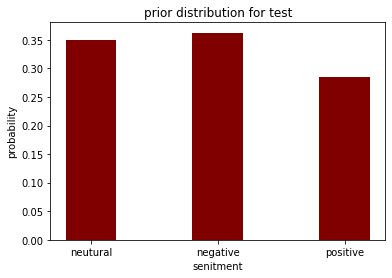

In [ ]:
# prior distribution:
sentiment_list = ['neutural','negative','positive']
values = prior_vec_v/np.sum(prior_vec_t)
plt.bar(sentiment_list, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment")
plt.ylabel("probability")
plt.title("prior distribution for test")
plt.show()

Text(0.5, 1.0, 'Histogram of length of each sentence in test data')

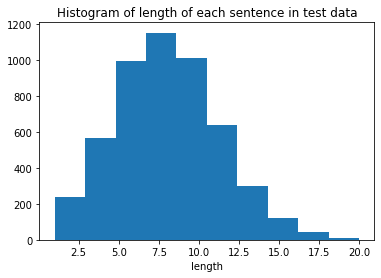

In [ ]:
len_sentence_list = []
for i in range(len(len_sentence_t)):
  len_sentence_list.append(len(len_sentence_t[i]))
plt.hist(len_sentence_list)
plt.xlabel('length')
plt.title('Histogram of length of each sentence in test data')


In [ ]:
print(f"mean of length of each sentence (test) = {np.mean(len_sentence_list)}")
print(f"variance of length of each sentence (test) = {np.var(len_sentence_list)}")

mean of length of each sentence (test) = 7.956187092954411
variance of length of each sentence (test) = 11.21378992197274


Text(0.5, 1.0, 'Histogram of number of images in each Conversation for test data')

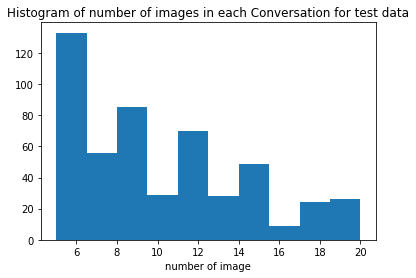

In [ ]:
#number of image in each Conversation
plt.hist(len_image_per_sample_t)
plt.xlabel('number of image')
plt.title('Histogram of number of images in each Conversation for test data')


In [ ]:
print(f"mean of number of images in each Conversation(validation) = {np.mean(len_image_per_sample_t)}")
print(f"variance of number of images in each Conversation(validation) = {np.var(len_image_per_sample_t)}")

mean of number of images in each Conversation(validation) = 9.954813359528487
variance of number of images in each Conversation(validation) = 17.752378599742936


Text(0.5, 1.0, 'Histogram of number of faces in each image for test data')

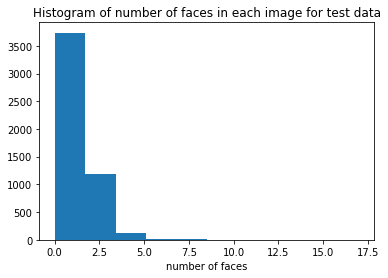

In [ ]:
#number of faces in each image
plt.hist(face_per_imge_library_t)
plt.xlabel('number of faces')
plt.title('Histogram of number of faces in each image for test data')


In [ ]:
print(f"mean of number of faces in each image(test) = {np.mean(face_per_imge_library_t)}")
print(f"variance of number of faces in each image(test) = {np.var(face_per_imge_library_t)}")

mean of number of faces in each image(test) = 1.2800473653049143
variance of number of faces in each image(test) = 0.9369671972828748


Text(0.5, 1.0, 'Histogram of number of faces in each image for test data')

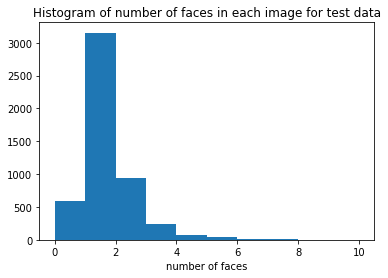

In [ ]:
face_per_imge_library_modified = face_per_imge_library_t.copy()
face_per_imge_library_modified = np.array(face_per_imge_library_modified) 
face_per_imge_library_modified[face_per_imge_library_modified>10] = 10
plt.hist(face_per_imge_library_modified)
plt.xlabel('number of faces')
plt.title('Histogram of number of faces in each image for test data')

In [ ]:
print(f"mean of number of faces in each image(validation) = {np.mean(face_per_imge_library_modified)}")
print(f"variance of number of faces in each image(validation) = {np.var(face_per_imge_library_modified)}")

mean of number of faces in each image(validation) = 1.2786658772449182
variance of number of faces in each image(validation) = 0.9032018514565178


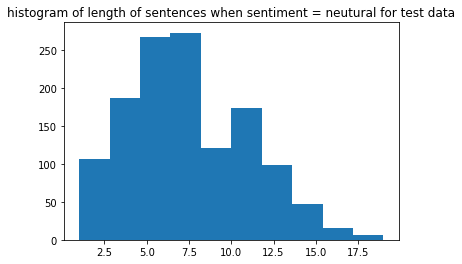

In [ ]:
len_sentence_list_0 = []
len_sentence_list_1 = []
len_sentence_list_2 = []

for i in range(len(len_sentiment_0_t)):
  len_sentence_list_0.append(len(len_sentiment_0_t[i]))

for i in range(len(len_sentiment_1_t)):
  len_sentence_list_1.append(len(len_sentiment_1_t[i]))

for i in range(len(len_sentiment_2_t)):
  len_sentence_list_2.append(len(len_sentiment_2_t[i]))
plt.hist(len_sentence_list_0)
plt.title('histogram of length of sentences when sentiment = neutural for test data')
plt.show()

<ipython-input-126-47a40ebee64c>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(len_sentence_list_0)


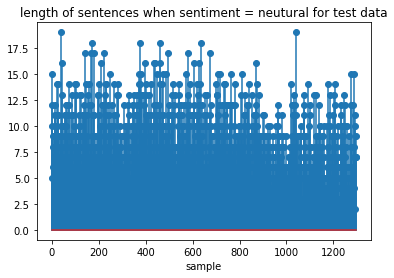

In [ ]:
plt.stem(len_sentence_list_0)
plt.title('length of sentences when sentiment = neutural for test data')
plt.xlabel('sample')
plt.show()

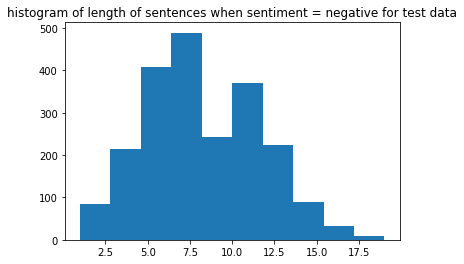

In [ ]:
plt.hist(len_sentence_list_1)
plt.title('histogram of length of sentences when sentiment = negative for test data')
plt.show()

<ipython-input-130-79ccb391ac05>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(np.asarray(len_sentence_list_1))


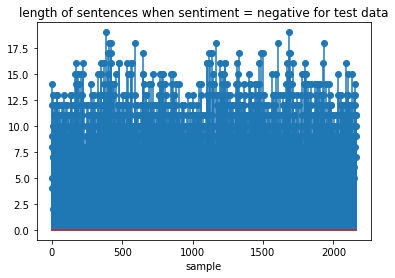

In [ ]:
plt.stem(np.asarray(len_sentence_list_1))
plt.title('length of sentences when sentiment = negative for test data')
plt.xlabel('sample')
plt.show()

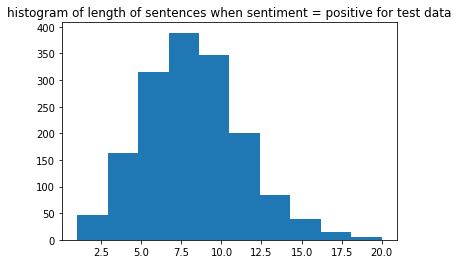

In [ ]:
plt.hist(len_sentence_list_2)
plt.title('histogram of length of sentences when sentiment = positive for test data')
plt.show()

<ipython-input-131-0bfc604109c2>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(np.asarray(len_sentence_list_2))


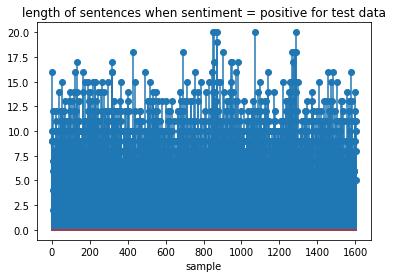

In [ ]:
plt.stem(np.asarray(len_sentence_list_2))
plt.title('length of sentences when sentiment = positive for test data')
plt.xlabel('sample')
plt.show()

Text(0, 0.5, 'length')

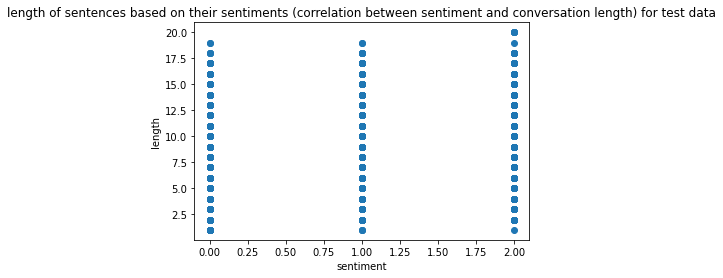

In [ ]:
array_0 = np.asarray(len_sentence_list_0)
array_1 = np.asarray(len_sentence_list_1)
array_2 = np.asarray(len_sentence_list_2)

sentiment_array_0 = np.ones((len(array_0)))*0
sentiment_array_1 = np.ones((len(array_1)))*1
sentiment_array_2 = np.ones((len(array_2)))*2

len_array = np.hstack((array_0,array_1,array_2))
sentiment_array = np.hstack((sentiment_array_0,sentiment_array_1,sentiment_array_2))

plt.scatter(sentiment_array,len_array)
plt.title('length of sentences based on their sentiments (correlation between sentiment and conversation length) for test data')
plt.xlabel('sentiment')
plt.ylabel('length')

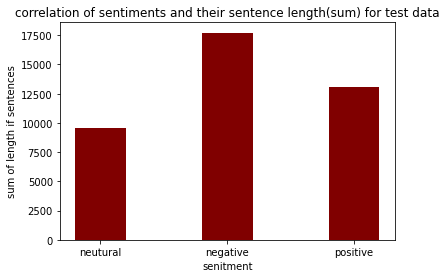

In [ ]:
# now plotting length of sentences based of their sentiment
len_sentence_sentiment = np.zeros((3,))
len_sentence_sentiment[0] = np.sum(len_sentence_list_0)
len_sentence_sentiment[1] = np.sum(len_sentence_list_1)
len_sentence_sentiment[2] = np.sum(len_sentence_list_2)

plt.bar(sentiment_list, len_sentence_sentiment, color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment")
plt.ylabel("sum of length if sentences")
plt.title("correlation of sentiments and their sentence length(sum) for test data")
plt.show()

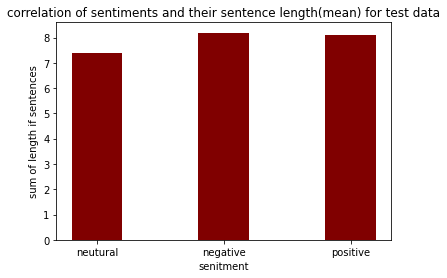

In [ ]:
# now plotting length of sentences based of their sentiment
len_sentence_sentiment = np.zeros((3,))
len_sentence_sentiment[0] = np.mean(len_sentence_list_0)
len_sentence_sentiment[1] = np.mean(len_sentence_list_1)
len_sentence_sentiment[2] = np.mean(len_sentence_list_2)

plt.bar(sentiment_list, len_sentence_sentiment, color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment")
plt.ylabel("sum of length if sentences")
plt.title("correlation of sentiments and their sentence length(mean) for test data")
plt.show()

In [ ]:
str_sentiment_pattern = []
for pattern in sentiment_pattern_t:
  str_pattern = ""
  for character in pattern:
    if character == 0:
      str_pattern = str_pattern + 'neutural_'
    elif character == 1:
      str_pattern = str_pattern + 'negative_'
    else:
      str_pattern = str_pattern + 'positive_'
  str_pattern = str_pattern[0:-1]
  str_sentiment_pattern.append(str_pattern)


In [ ]:
unique_pattern = unique_list_func(str_sentiment_pattern)
my_dict = {i:str_sentiment_pattern.count(i) for i in unique_pattern}
my_dict


{'negative_neutural': 10,
 'neutural_negative_neutural_positive_neutural_negative_positive_negative_positive_neutural_negative': 1,
 'neutural_negative_positive_negative_neutural_negative_neutural_negative': 1,
 'negative_neutural_negative_neutural_negative_neutural': 3,
 'neutural_negative_neutural_negative_neutural_negative_neutural': 2,
 'neutural_negative_neutural_negative_positive_neutural_positive_neutural': 2,
 'positive_neutural_positive_negative_neutural_positive_neutural_positive_negative': 1,
 'negative': 18,
 'neutural_positive_neutural_positive_neutural_negative_positive_negative_positive_neutural': 1,
 'neutural_positive_neutural_positive_negative': 2,
 'neutural_negative_positive_negative_neutural_positive_negative_neutural_negative': 2,
 'neutural_negative_positive': 8,
 'negative_positive_negative': 22,
 'neutural_negative_neutural_positive_negative_positive_negative_neutural_positive_negative_positive_negative': 1,
 'negative_neutural_positive_negative_neutural': 2,
 

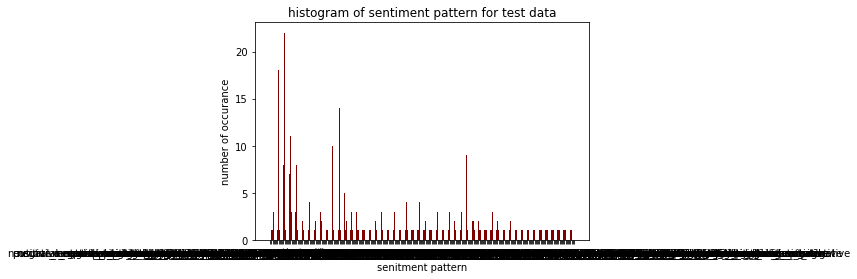

In [ ]:
plt.bar(my_dict.keys(), my_dict.values(), color ='maroon',
        width = 0.4)
 
plt.xlabel("senitment pattern")
plt.ylabel("number of occurance")
plt.title("histogram of sentiment pattern for test data")
plt.show()

In [ ]:
print(f"number of all sentiment patterns in validation data= {len(unique_pattern)}")
mean_of_conv = np.round(np.mean(len_image_per_sample_t))
possible = 3 * (2**(mean_of_conv-1))
print(f"number of all possible sentiment patterns for test data = {int(possible)}")



number of all sentiment patterns in validation data= 255
number of all possible sentiment patterns for test data = 1536


if we compare train, validation and test data, we can see same pattern in different parts except number of unique sentiment pattern, and it is because of number of samples are much lower in validation and test data compared to train data so we see less unique patterns in that datasets.
in the end it seems if we train data only on train data, it shouldn't have a certain bias that lower it performance in test or validation data.